In [40]:
from matplotlib.cm import ScalarMappable
import numpy as np
import h5py
from pathlib import Path
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import ticker
from matplotlib.colors import Normalize
import numpy as np
import h5py
from pathlib import Path
from DDACSDataset import DDACSDataset
from utils_DDACS import  extract_mesh, extract_element_thickness, extract_point_springback, extract_point_cloud
import torch
from tqdm import tqdm
import time
from pathlib import Path

In [41]:
data_dir = Path("/mnt/data/darus/")

dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

# Display sample simulation
sim_id, metadata, h5_path = dataset[0]
print(f"Sample simulation: {sim_id}")
print(f"File: {h5_path}")
print(f"Metadata: {metadata}")

try:
    import scienceplots

    plt.style.use(["science"])
except ImportError as exc:
    print("For proper plotting, use scienceplots")

# Standard figure sizes (width, height) in inches based on paper dimensions.
FIGURE_SIZES = {
    "single_col": (3.5, 2.6),  # Single column
    "single_col_cb": (5, 3.5),  # Single column, with colorbar
    "single_col_tall": (3.5, 3.5),  # Single column, square-ish
    "double_col": (7.0, 3.0),  # Double column, wide
    "double_col_tall": (7.0, 4.5),  # Double column, taller
    "square": (3.5, 3.5),  # Square single column
    "poster": (10, 8),  # For presentations/posters
}

# Visualization constants for consistency
FIGURE_SIZE = FIGURE_SIZES["double_col"]
FIGURE_DPI = 150
AXIS_LIMITS = [0, 110]
VIEW_ELEVATION = 30
VIEW_AZIMUTH = 45

# Component settings
COMPONENT_COLORS = {"blank": "red"}
COMPONENT_NAMES = {
    "blank": "Blank (Workpiece)",
}


Loaded 32071 simulations
Sample simulation: 16039
File: /mnt/data/darus/h5/16039.h5
Metadata: [1.0e+00 0.0e+00 0.0e+00 3.0e+01 9.0e-01 5.0e-02 9.5e-01 1.0e+05]
For proper plotting, use scienceplots


In [48]:

# Variables
OPERATION = 10  # Can be 10 or 20.

# Get springback information
final_coords, displacement_vectors = extract_point_springback(
    h5_path, operation=OPERATION
)
node_coords, triangles = extract_mesh(h5_path, operation=OPERATION, component='blank', timestep = 2)

final_coords_test = node_coords + displacement_vectors

# Calculate displacement magnitude for color mapping
displacement_magnitude = np.linalg.norm(displacement_vectors, axis=1)

# Settings for plotting.
global_springback_min = 0.0
global_springback_max = 1.4

# Statistics
print(f"Springback statistics:")
print(f" - Mean magnitude: {displacement_magnitude.mean():.4f} mm")
print(f" - Max magnitude: {displacement_magnitude.max():.4f} mm")
print(f" - Min magnitude: {displacement_magnitude.min():.4f} mm")
print(f" - Std deviation: {displacement_magnitude.std():.4f} mm")

Springback statistics:
 - Mean magnitude: 0.2124 mm
 - Max magnitude: 0.7167 mm
 - Min magnitude: 0.0000 mm
 - Std deviation: 0.1983 mm


<>:70: SyntaxWarning: invalid escape sequence '\&'
<>:70: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipykernel_233695/3470324508.py:70: SyntaxWarning: invalid escape sequence '\&'
  ax.set_title(f"Original Springback: Points \& Vectors - Simulation {sim_id} - OP{OPERATION}")


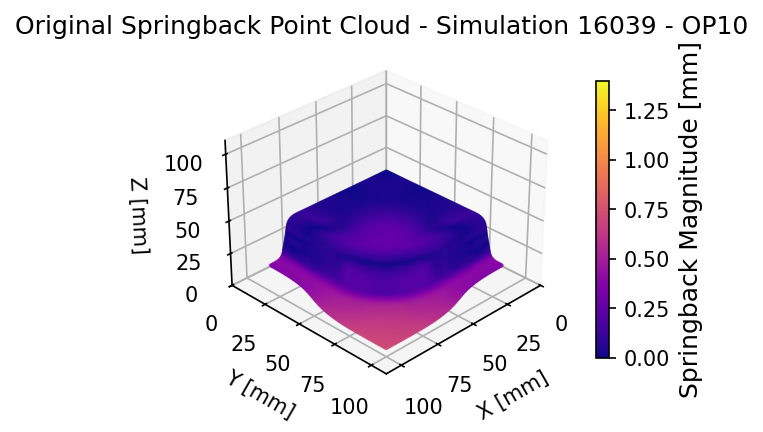

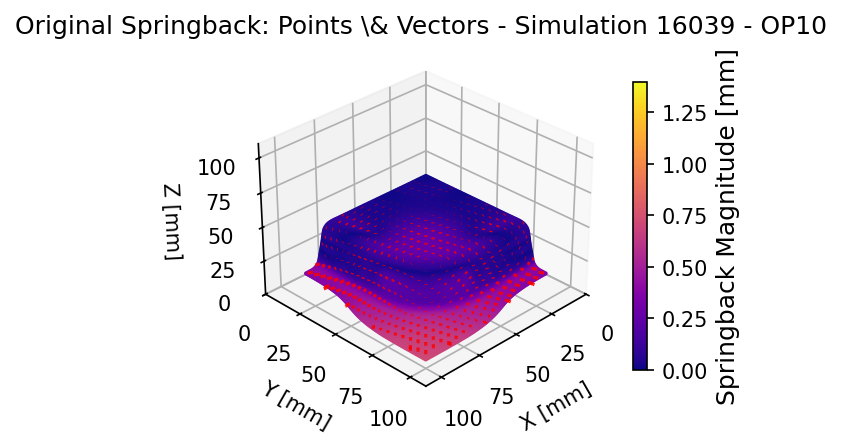

In [50]:
fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection="3d")

norm = Normalize(vmin=global_springback_min, vmax=global_springback_max)
colors = plt.cm.plasma(norm(displacement_magnitude))


scatter = ax.scatter(
    final_coords[:, 0], final_coords[:, 1], final_coords[:, 2], c=colors, s=1, alpha=0.8
)

sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
cbar.set_label("Springback Magnitude [mm]", fontsize=12)

ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.set_title(f"Original Springback Point Cloud - Simulation {sim_id} - OP{OPERATION}")

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

plt.show()

# Variables
STEP = 25  # Resolution/Amount of arrows
SCALING = 10  # Scaling of the arrows

fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_axes([0.1, 0.1, 0.6, 0.8], projection="3d")

scatter = ax.scatter(
    final_coords[:, 0], final_coords[:, 1], final_coords[:, 2], c=colors, s=1, alpha=1
)

# Vectors (subsampled)
coords_sub = final_coords[::STEP]
vectors_sub = displacement_vectors[::STEP] * SCALING

ax.quiver(
    coords_sub[:, 0],
    coords_sub[:, 1],
    coords_sub[:, 2],
    vectors_sub[:, 0],
    vectors_sub[:, 1],
    vectors_sub[:, 2],
    color="red",
    alpha=0.8,
    arrow_length_ratio=0.1,
)


sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
cbar.set_label("Springback Magnitude [mm]", fontsize=12)

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.set_title(f"Original Springback: Points \& Vectors - Simulation {sim_id} - OP{OPERATION}")

plt.show()

In [51]:
import os
import numpy as np


# h5_path = "/path/to/your/file.h5"     #
OPERATION = 10                        # or 20
sample_id = "16039"                   
pred_dir  = "/home/RUS_CIP/st186731/Grit/GRIT/results/ddacs-node-regression/preds_new/"
data_root = "/mnt/data/jiang"         # where node_index.npy would live (if present)
SCALE = 1.0                           # set to 1000.0 if you need m->mm, etc.

# 1) Get mesh (coords + triangles)
node_coords, triangles = extract_mesh(
    h5_path, operation=OPERATION, component='blank', timestep=2
)                                      # node_coords: (N,3)

# 2) Load predicted displacement (N,3)
pred_path = os.path.join(pred_dir, f"{sample_id}_pred_node_displacement.npy")
displacement_vectors = np.load(pred_path) * SCALE   # (N,3)

# 2a) If you saved node_index during preprocessing and your mesh is in
#      the original node order, reorder predictions accordingly:
idx_path = os.path.join(data_root, f"{sample_id}_node_index.npy")
if os.path.exists(idx_path):
    node_index = np.load(idx_path)     # shape (N,)
    # reorder predictions so they match mesh/node_coords order
    order = np.argsort(node_index)
    displacement_vectors = displacement_vectors[order]

# Sanity check
assert displacement_vectors.shape == node_coords.shape, \
    f"shape mismatch: preds {displacement_vectors.shape} vs coords {node_coords.shape}"

# 3) Apply displacement
final_coords = node_coords + displacement_vectors

# 4) Magnitudes for coloring / stats
displacement_magnitude = np.linalg.norm(displacement_vectors, axis=1)

# 5) Stats
print("Springback statistics (pred):")
print(f" - Mean magnitude: {displacement_magnitude.mean():.4f}")
print(f" - Max magnitude:  {displacement_magnitude.max():.4f}")
print(f" - Min magnitude:  {displacement_magnitude.min():.4f}")
print(f" - Std deviation:  {displacement_magnitude.std():.4f}")

# 6) (optional) plotting with your existing routine
global_springback_min = 0.0
global_springback_max = 1.4
# plot_mesh(final_coords, triangles, displacement_magnitude, vmin=global_springback_min, vmax=global_springback_max)


Springback statistics (pred):
 - Mean magnitude: 0.1969
 - Max magnitude:  0.4673
 - Min magnitude:  0.0015
 - Std deviation:  0.1305


<>:70: SyntaxWarning: invalid escape sequence '\&'
<>:70: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipykernel_233695/1467000802.py:70: SyntaxWarning: invalid escape sequence '\&'
  ax.set_title(f"predicted Springback: Points \& Vectors - Simulation {sample_id} - OP{OPERATION}")


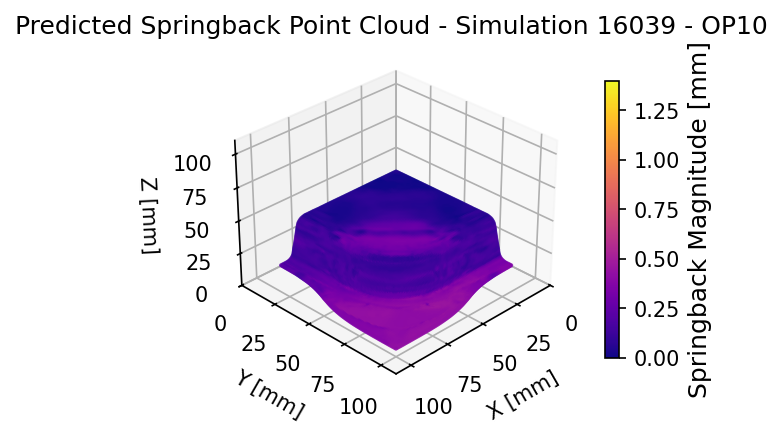

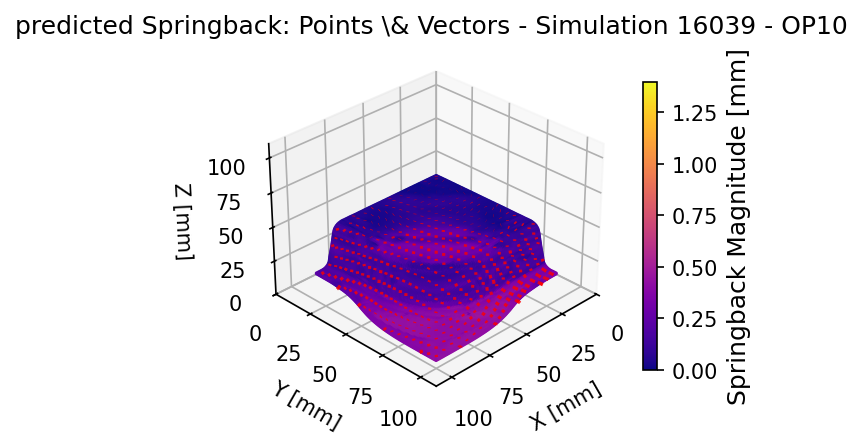

In [ ]:
fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection="3d")

norm = Normalize(vmin=global_springback_min, vmax=global_springback_max)
colors = plt.cm.plasma(norm(displacement_magnitude))


scatter = ax.scatter(
    final_coords[:, 0], final_coords[:, 1], final_coords[:, 2], c=colors, s=1, alpha=0.8
)

sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
cbar.set_label("Springback Magnitude [mm]", fontsize=12)

ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.set_title(f"Predicted Springback Point Cloud - Simulation {sample_id} - OP{OPERATION}")

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

plt.show()

# Variables
STEP = 25  # Resolution/Amount of arrows
SCALING = 10  # Scaling of the arrows

fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_axes([0.1, 0.1, 0.6, 0.8], projection="3d")

scatter = ax.scatter(
    final_coords[:, 0], final_coords[:, 1], final_coords[:, 2], c=colors, s=1, alpha=1
)

# Vectors (subsampled)
coords_sub = final_coords[::STEP]
vectors_sub = displacement_vectors[::STEP] * SCALING

ax.quiver(
    coords_sub[:, 0],
    coords_sub[:, 1],
    coords_sub[:, 2],
    vectors_sub[:, 0],
    vectors_sub[:, 1],
    vectors_sub[:, 2],
    color="red",
    alpha=0.8,
    arrow_length_ratio=0.1,
)


sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
cbar.set_label("Springback Magnitude [mm]", fontsize=12)

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.set_title(f"Predicted Springback: Points \& Vectors - Simulation {sample_id} - OP{OPERATION}")

plt.show()

<>:70: SyntaxWarning: invalid escape sequence '\&'
<>:70: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipykernel_233695/3229807202.py:70: SyntaxWarning: invalid escape sequence '\&'
  ax.set_title(f"Springback: Points \& Vectors - Simulation {sim_id} - OP{OPERATION}")


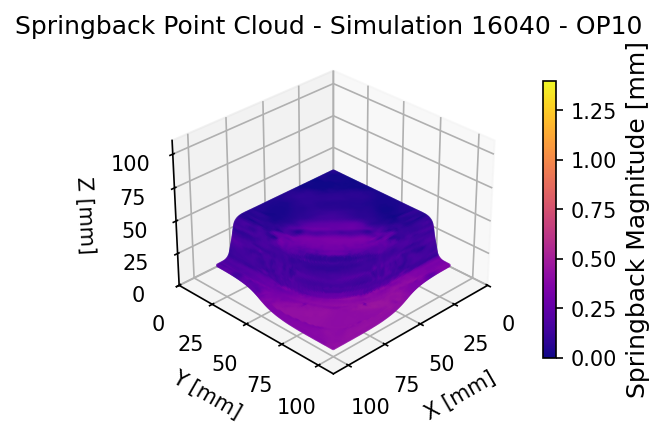

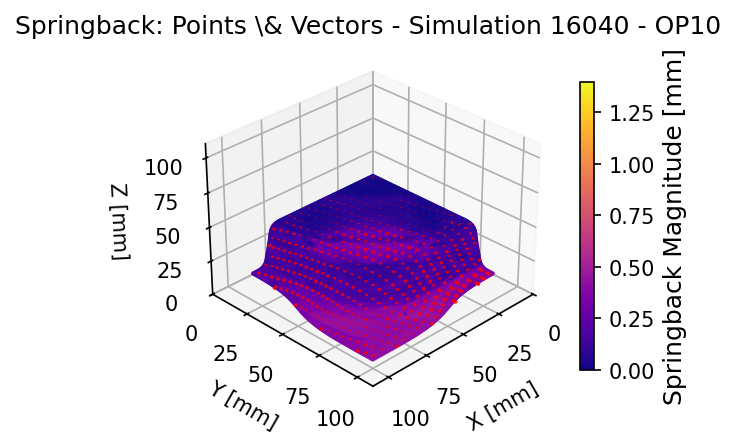

In [22]:
fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection="3d")

norm = Normalize(vmin=global_springback_min, vmax=global_springback_max)
colors = plt.cm.plasma(norm(displacement_magnitude))


scatter = ax.scatter(
    final_coords_test[:, 0], final_coords_test[:, 1], final_coords_test[:, 2], c=colors, s=1, alpha=0.8
)

sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
cbar.set_label("Springback Magnitude [mm]", fontsize=12)

ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.set_title(f"Springback Point Cloud - Simulation {sim_id} - OP{OPERATION}")

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

plt.show()

# Variables
STEP = 25  # Resolution/Amount of arrows
SCALING = 10  # Scaling of the arrows

fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_axes([0.1, 0.1, 0.6, 0.8], projection="3d")

scatter = ax.scatter(
    final_coords_test[:, 0], final_coords_test[:, 1], final_coords_test[:, 2], c=colors, s=1, alpha=1
)

# Vectors (subsampled)
coords_sub = final_coords_test[::STEP]
vectors_sub = displacement_vectors[::STEP] * SCALING

ax.quiver(
    coords_sub[:, 0],
    coords_sub[:, 1],
    coords_sub[:, 2],
    vectors_sub[:, 0],
    vectors_sub[:, 1],
    vectors_sub[:, 2],
    color="red",
    alpha=0.8,
    arrow_length_ratio=0.1,
)


sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
cbar.set_label("Springback Magnitude [mm]", fontsize=12)

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.set_title(f"Springback: Points \& Vectors - Simulation {sim_id} - OP{OPERATION}")

plt.show()